In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [1]:
!nvidia-smi

Wed May 26 09:27:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/split_images.zip > /dev/null

In [4]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [5]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/content/split_images/60-40/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/split_images/60-40/train_attack/train_attack_equ_*.jpg', recursive=True):
    train_attack.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/split_images/60-40/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/split_images/60-40/test_attack/test_attack_equ_*.jpg', recursive=True):
    test_attack.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

train_normal = np.array(train_normal)
train_attack = np.array(train_attack)
test_normal = np.array(test_normal)
test_attack = np.array(test_attack)

In [6]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack)

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

((1285, 64, 64), (1182, 64, 64), (1285, 64, 64), (788, 64, 64))

In [7]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
                   train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
                  test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal))

In [37]:
## if no augmented data is needed, run this cell
train = np.vstack((train_attack, train_normal))
test = np.vstack((test_attack, test_normal))

train.shape, test.shape

((2467, 64, 64), (2073, 64, 64))

In [8]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((12335, 64, 64, 1), (10365, 64, 64, 1))

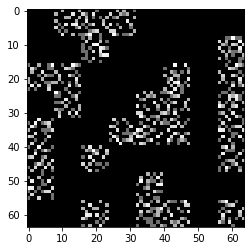

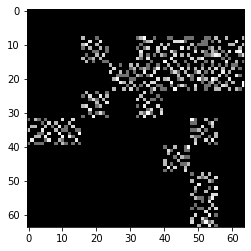

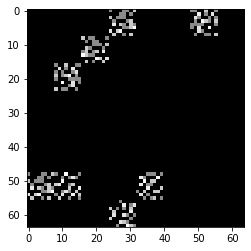

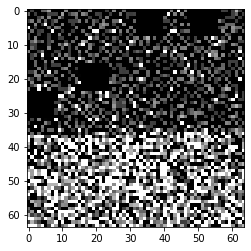

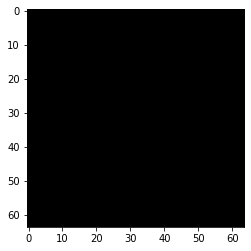

In [ ]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

## No augmented data

In [39]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

## Augmented data

In [9]:
## create the training and testing data labels
## run this cell if using augmented data with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

## Augmented data but no rotate

In [53]:
## create the training and testing data labels
## run this cell if using augmented data and not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [10]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 12330       0       1
 12331       0       1
 12332       0       1
 12333       0       1
 12334       0       1
 
 [12335 rows x 2 columns],        attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 10360       0       1
 10361       0       1
 10362       0       1
 10363       0       1
 10364       0       1
 
 [10365 rows x 2 columns])

In [11]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 7)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 7)

In [12]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Convolution2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Convolution2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         3

In [13]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 256, epochs = 300)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/300
49/49 [==============================] - 33s 19ms/step - loss: 2.7232 - accuracy: 0.5618
Epoch 2/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6822 - accuracy: 0.5887
Epoch 3/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6677 - accuracy: 0.5964
Epoch 4/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6621 - accuracy: 0.6036
Epoch 5/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6575 - accuracy: 0.6124
Epoch 6/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6535 - accuracy: 0.6172
Epoch 7/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6482 - accuracy: 0.6167
Epoch 8/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6418 - accuracy: 0.6251
Epoch 9/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6382 - accuracy: 0.6312
Epoch 10/300
49/49 [==============================] - 1s 16ms/step - loss: 0.6364 - accuracy: 0.631

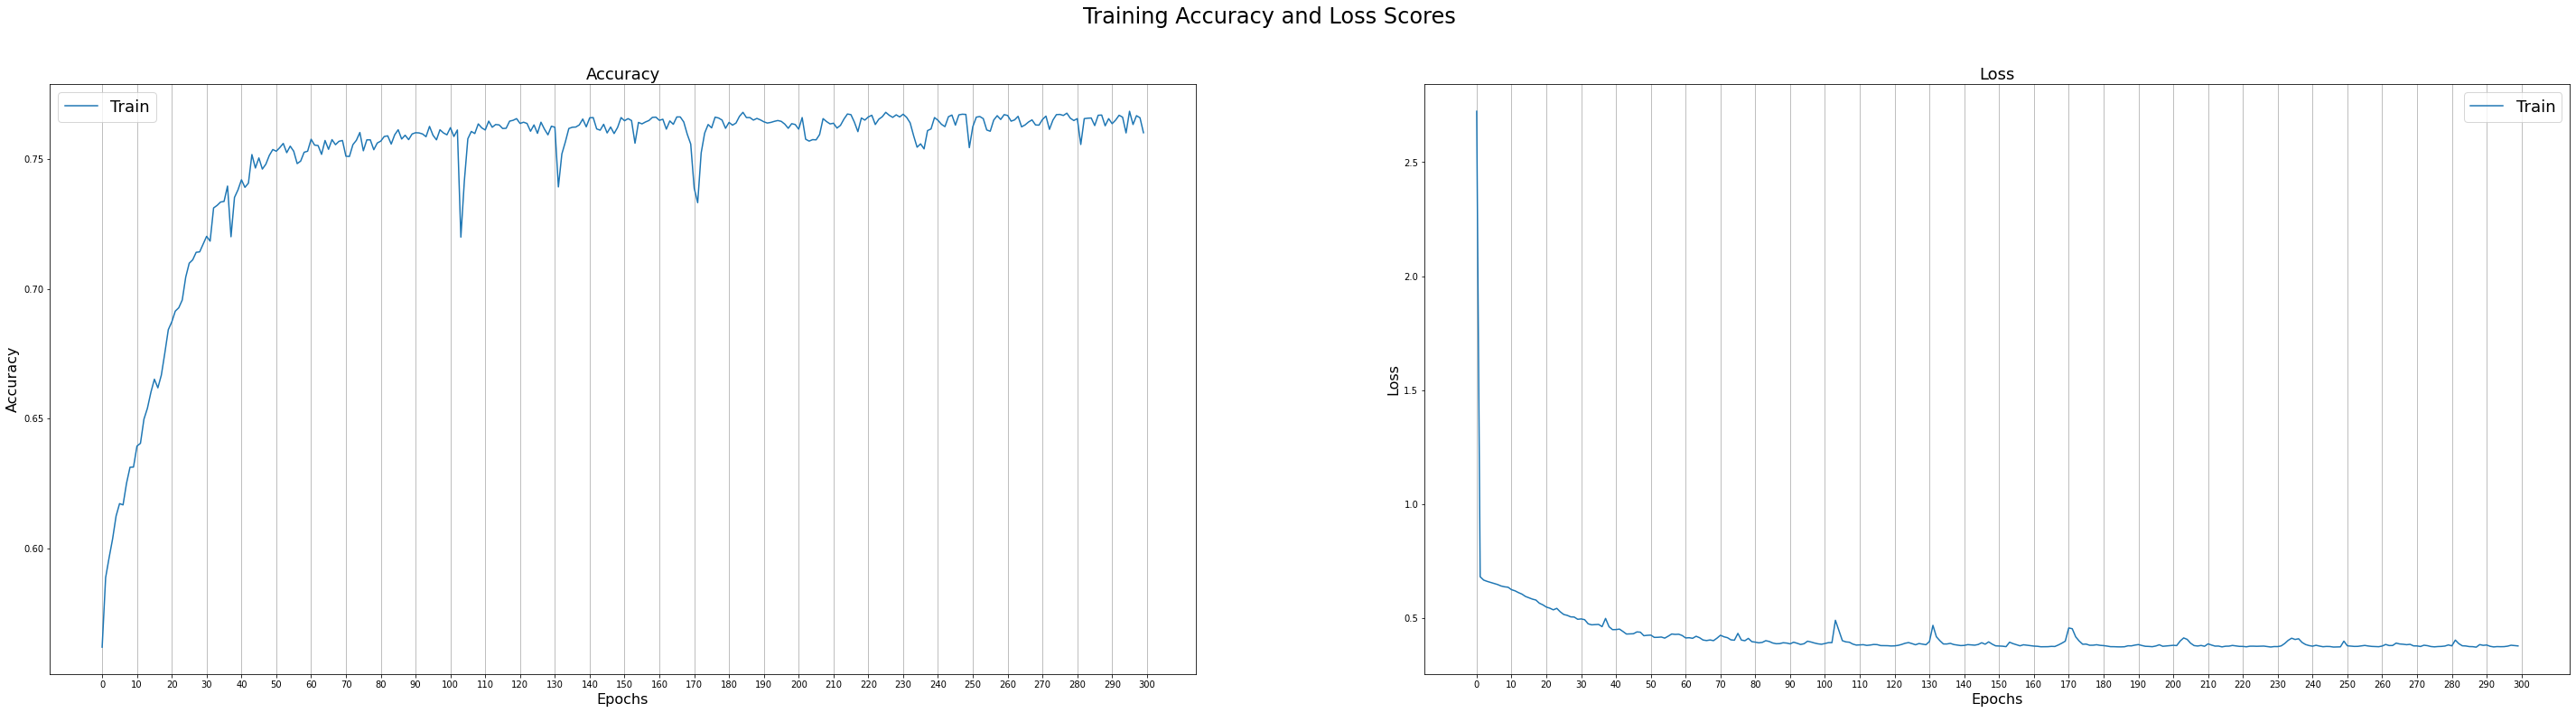

In [14]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 310, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 310, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [15]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 512, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 0.7532	Accuracy = 68.22%


In [16]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.98028, 0.01971],
       [0.49917, 0.50078],
       [0.49917, 0.50078],
       [0.49917, 0.50078],
       [0.81274, 0.18728],
       [0.49917, 0.50078],
       [0.99951, 0.00049],
       [0.0089 , 0.98963],
       [0.99693, 0.00308],
       [0.30898, 0.69106],
       [0.00001, 0.99998],
       [0.00036, 0.99966],
       [0.99787, 0.00213],
       [0.49917, 0.50078],
       [0.49917, 0.50078],
       [0.49917, 0.50078],
       [0.71101, 0.28891],
       [0.0002 , 0.99981],
       [0.49917, 0.50078],
       [0.00463, 0.99554]], dtype=float32)

In [17]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # # cnn.add(Dropout(0.5))

    # ## convolution 6
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    # cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(64, activation='relu'))
    # cnn.add(Dense(32, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 256, epochs = 300)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

Epoch 1/300
33/33 [==============================] - 1s 24ms/step - loss: 0.8640 - accuracy: 0.5819
Epoch 2/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6650 - accuracy: 0.5995
Epoch 3/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6633 - accuracy: 0.6050
Epoch 4/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6621 - accuracy: 0.6073
Epoch 5/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6602 - accuracy: 0.6058
Epoch 6/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6582 - accuracy: 0.6132
Epoch 7/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6589 - accuracy: 0.6113
Epoch 8/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6566 - accuracy: 0.6144
Epoch 9/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6549 - accuracy: 0.6196
Epoch 10/300
33/33 [==============================] - 1s 16ms/step - loss: 0.6519 - accuracy: 0.6230